In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
import torch
import torchvision.transforms.functional as TF

from datasets import load_dataset
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/7.97M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/6.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [3]:
WIDTH, HEIGHT = 100, 100

def preprocess_function(examples):
    # Load and process images
    images = [image_file.resize((WIDTH, HEIGHT), Image.Resampling.LANCZOS) for image_file in examples['image']]
    # Tokenize captions
    captions = [caption for caption in examples['caption_choices']]
    inputs = processor(images=images, text=captions, return_tensors="pt", padding='max_length', truncation=True)

    # Convert tensors to lists (map expects lists)
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "pixel_values": inputs["pixel_values"],
        "labels": inputs["input_ids"]
    }

# Apply the preprocessing function to the dataset
processed_dataset = ds.map(preprocess_function, batched=True, remove_columns=ds["train"].column_names)

Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

In [4]:
training_args = TrainingArguments(
    output_dir="./blip-caption-generator",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    eval_steps=500,
    save_total_limit=2,
)


In [5]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
)


In [9]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'pixel_values'],
        num_rows: 2340
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'pixel_values'],
        num_rows: 130
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'pixel_values'],
        num_rows: 131
    })
})

In [6]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rohitrathore0812 (rohitrathore0812-securelayer7) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,9.353800
20,7.298100
30,6.106300
40,4.916500
50,3.702000
60,2.513200
70,1.442300
80,0.708200
90,0.313300
100,0.167600


TrainOutput(global_step=1755, training_loss=0.23212531072079626, metrics={'train_runtime': 4238.3395, 'train_samples_per_second': 1.656, 'train_steps_per_second': 0.414, 'total_flos': 4.1658340386196685e+18, 'train_loss': 0.23212531072079626, 'epoch': 3.0})

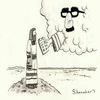

In [30]:
test_image = ds["test"]["image"][0].resize((WIDTH, HEIGHT), Image.Resampling.LANCZOS)
test_image

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:


test_image = TF.to_tensor(test_image)

In [39]:


# Process the image
inputs = processor(images=test_image.to(device), return_tensors="pt")
inputs = inputs.to(device)
# Generate caption
outputs = model.generate(**inputs)
caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", caption)


Generated Caption: two


In [26]:
from numba import cuda

device_array = cuda.to_device(numpy_array)